In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [1]:
import utils.data_loader as loader
import utils.torch_resistance_metrics as ermet
import networkx as nx
import torch
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [66]:
ADD_N_EDGES = 120
DRAW = False
DATASET = 'UNC28'
DEVICE = 'cuda'

In [67]:
GW = loader.load_data(DATASET, device=DEVICE)
GW.num_edges, GW.num_nodes

exact


(65287, 3985)

In [68]:
initialR = GW.get_effective_resistance()
initialER = initialR.cpu().sum().item()/2
initialER

1186944.125

In [69]:
GW.sens.unique().detach().cpu().numpy()

array([0., 1.], dtype=float32)

In [70]:
def get_group_metrics(R, group, filter):
    return {
        'total_er': ermet.group_total_er(R, group).cpu().item(),
        'diameter': ermet.group_diam(R, group).cpu().item(),
        'avg_diam': ermet.group_avg_diam(R, group).cpu().item(),
        'avg_betw': ermet.group_betwenness(R, group, filter).sum(axis=1).mean().cpu().item(),
        'std_betw': ermet.group_betwenness(R, group, filter).sum(axis=1).std().cpu().item()
    }

In [71]:
initial_0_metrics = get_group_metrics(initialR, GW.sens==0, ~GW.edge_mask)
initial_1_metrics = get_group_metrics(initialR, GW.sens==1, ~GW.edge_mask)

for m in initial_0_metrics:
    print(f'Fair {m.upper()}: {initial_0_metrics[m] - initial_1_metrics[m]:.4f}')
    print(f'\tGroup 0: {initial_0_metrics[m]:.2f}, - Group 1: {initial_1_metrics[m]:.2f}')

Fair TOTAL_ER: -22.3698
	Group 0: 586.29, - Group 1: 608.66
Fair DIAMETER: 0.0743
	Group 0: 3.30, - Group 1: 3.23
Fair AVG_DIAM: -0.0062
	Group 0: 2.10, - Group 1: 2.11
Fair AVG_BETW: 0.0097
	Group 0: 2.00, - Group 1: 1.99
Fair STD_BETW: -0.1020
	Group 0: 0.63, - Group 1: 0.73


In [72]:
results_dict = {}
unique_groups = GW.sens.unique().detach().cpu().numpy()
for group in unique_groups:
    results_dict[group] = {}
    group_res = ermet.get_group_metrics(GW.get_effective_resistance().detach().cpu(),
                                             GW.sens.detach().cpu()==group,
                                             ~GW.edge_mask.detach().cpu())
    for metric in group_res:
        results_dict[group][metric] = [group_res[metric]]

In [73]:
results_dict

{0.0: {'total_er': [586.2865600585938],
  'diameter': [3.3024215698242188],
  'avg_diam': [2.1047725677490234],
  'avg_betw': [2.0035741329193115],
  'std_betw': [0.6323962211608887]},
 1.0: {'total_er': [608.65625],
  'diameter': [3.2281270027160645],
  'avg_diam': [2.110983371734619],
  'avg_betw': [1.9938938617706299],
  'std_betw': [0.7344139218330383]}}

In [74]:
colors = np.array(['#0F71F2', '#F2A20C'])#https://color.adobe.com/Google-Color-Scheme-color-theme-2177284/
node_colors = colors[GW.sens.detach().cpu().long()]

In [75]:
if DRAW:
    plt.figure(figsize=(5,4))
    G = nx.from_edgelist(GW.edgelist.numpy().T)
    R = GW.get_effective_resistance().cpu()
    rg0 = ermet.group_total_er(R, (GW.sens==0).cpu()).cpu().item()
    rg1 = ermet.group_total_er(R,(GW.sens==1).cpu()).cpu().item()
    plt.title(f'''$R_{{tot}} = {R.sum().item()/2:.2f}$
$Res_G(1)$={rg1:.2f}  - $Res_G(0)$={rg0:.2f} = {rg1-rg0:.2f}''')
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, with_labels=False,pos=pos, node_size=20, node_color=node_colors,  edge_color='gray', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./results/figures/graphs/{DATASET}{ADD_N_EDGES}original.png', dpi=300, bbox_inches='tight')

Weak edges

In [76]:
from utils.link_addition_torch import get_weakest_link, get_random_link, get_strongest_link

In [77]:
#GW.mode = 'woodbury'

In [78]:
weakTotalER = []

# Add ER diameters
for _ in tqdm(range(ADD_N_EDGES)):
    # get 2 random numbers between the range of 0 and num_nodes
    R = GW.get_effective_resistance()

    u,v = get_weakest_link(R.detach().cpu(), GW.edge_mask.detach().cpu(), GW.num_nodes)
    weakTotalER.append(R.cpu().detach().sum().item()/2)
    if GW.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        GW.add_link(u,v)

    

R = GW.get_effective_resistance()
R_cpu = R.detach().cpu()
weakTotalER.append(R_cpu.sum().item()/2)

100%|██████████| 120/120 [00:25<00:00,  4.65it/s]


In [79]:
GW.safety_checks()

True

In [80]:
GW.num_edges, GW.num_nodes, GW.get_effective_resistance().cpu().sum().item()/2

(65407, 3985, 1011336.9375)

In [81]:
weak_0_metrics = get_group_metrics(R, GW.sens==0, ~GW.edge_mask)
weak_1_metrics = get_group_metrics(R, GW.sens==1, ~GW.edge_mask)

for m in initial_0_metrics:
    print(f'Fair {m.upper()}: {weak_0_metrics[m] - weak_1_metrics[m]:.4f}')
    print(f'\tGroup 0: {weak_0_metrics[m]:.2f}, - Group 1: {weak_1_metrics[m]:.2f}')

Fair TOTAL_ER: -25.7565
	Group 0: 496.73, - Group 1: 522.48
Fair DIAMETER: -0.0001
	Group 0: 0.69, - Group 1: 0.69
Fair AVG_DIAM: -0.0065
	Group 0: 0.40, - Group 1: 0.41
Fair AVG_BETW: 0.0077
	Group 0: 2.00, - Group 1: 2.00
Fair STD_BETW: -0.1016
	Group 0: 0.61, - Group 1: 0.71


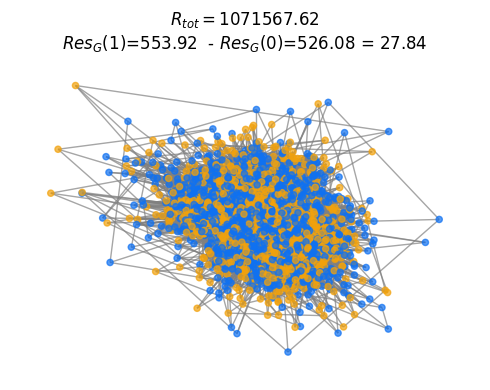

In [27]:
if DRAW:
    plt.figure(figsize=(5,4))
    G = nx.from_edgelist(GW.edgelist.numpy().T)
    R = GW.get_effective_resistance().cpu()
    rg0 = ermet.group_total_er(R, (GW.sens==0).cpu()).cpu().item()
    rg1 = ermet.group_total_er(R, (GW.sens==1).cpu()).cpu().item()
    plt.title(f'''$R_{{tot}} = {R.sum().item()/2:.2f}$
$Res_G(1)$={rg1:.2f}  - $Res_G(0)$={rg0:.2f} = {rg1-rg0:.2f}''')
    nx.draw(G, with_labels=False,pos=pos, node_size=20, node_color=node_colors, edge_color='gray', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./results/figures/graphs/{DATASET}{ADD_N_EDGES}ERPweak.png', dpi=300, bbox_inches='tight')

Random edges

In [20]:
GW = loader.load_data(DATASET, device=DEVICE)
GW.num_edges, GW.num_nodes, GW.get_effective_resistance().cpu().sum().item()/2

exact


(26749, 1034, 100225.921875)

In [21]:

randomedges = []

# Add ER diameters
for _ in tqdm(range(ADD_N_EDGES)):
    # get 2 random numbers between the range of 0 and num_nodes
    R = GW.get_effective_resistance()
    randomedges.append(R.cpu().detach().sum().item()/2)

    u,v = get_random_link(GW.edge_mask.detach().cpu(), GW.num_nodes)
    
    if GW.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        GW.add_link(u,v)

R = GW.get_effective_resistance()
R_cpu = R.detach().cpu()
randomedges.append(R_cpu.sum().item()/2)


100%|██████████| 50/50 [00:00<00:00, 51.55it/s]


In [22]:
GW.safety_checks()

True

In [23]:
GW.num_edges, GW.num_nodes, GW.get_effective_resistance().cpu().sum().item()/2

(26799, 1034, 94536.046875)

In [24]:
random_0_metrics = get_group_metrics(R, GW.sens==0, ~GW.edge_mask)
random_1_metrics = get_group_metrics(R, GW.sens==1, ~GW.edge_mask)

for m in initial_0_metrics:
    print(f'Fair {m.upper()}: {random_0_metrics[m] - random_1_metrics[m]:.4f}')
    print(f'\tGroup 0: {random_0_metrics[m]:.2f}, - Group 1: {random_1_metrics[m]:.2f}')

Fair TOTAL_ER: -31.2462
	Group 0: 172.31, - Group 1: 203.55
Fair DIAMETER: 0.0000
	Group 0: 4.23, - Group 1: 4.23
Fair AVG_DIAM: -0.0318
	Group 0: 2.25, - Group 1: 2.28
Fair AVG_BETW: 0.1168
	Group 0: 2.04, - Group 1: 1.92
Fair STD_BETW: 0.0655
	Group 0: 0.61, - Group 1: 0.55


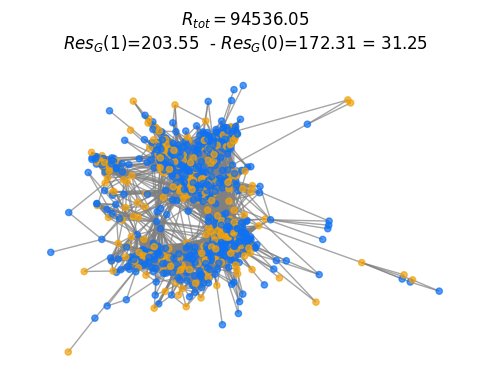

In [25]:
if DRAW:
    plt.figure(figsize=(5,4))
    G = nx.from_edgelist(GW.edgelist.numpy().T)
    R = GW.get_effective_resistance().cpu()
    rg0 = ermet.group_total_er(R, GW.sens==0).cpu().item()
    rg1 = ermet.group_total_er(R, GW.sens==1).cpu().item()
    plt.title(f'''$R_{{tot}} = {R.sum().item()/2:.2f}$
$Res_G(1)$={rg1:.2f}  - $Res_G(0)$={rg0:.2f} = {rg1-rg0:.2f}''')
    nx.draw(G, with_labels=False,pos=pos, node_size=20, node_color=node_colors, edge_color='gray', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./results/figures/graphs/{DATASET}{ADD_N_EDGES}random.png', dpi=300, bbox_inches='tight')

In [26]:
GW.sens

tensor([0., 1., 0.,  ..., 1., 0., 1.])

Strong edges:

In [27]:
GW = loader.load_data(DATASET, device=DEVICE)
GW.num_edges, GW.num_nodes, GW.get_effective_resistance().cpu().sum().item()/2

exact


(26749, 1034, 100225.921875)

In [28]:
# Add ER STRONG
strongTotalER = []
for _ in tqdm(range(ADD_N_EDGES)):
    # get 2 random numbers between the range of 0 and num_nodes
    R = GW.get_effective_resistance()
    R_cpu = R.detach().cpu()
    strongTotalER.append(R_cpu.sum().item()/2)
    
    u,v = get_strongest_link(R_cpu, GW.edge_mask.cpu().detach(), GW.num_nodes)

    if GW.is_edge(u,v):
        print('edge exists')
    else:
        GW.add_link(u,v)
    
    
R = GW.get_effective_resistance()
R_cpu = R.detach().cpu()
strongTotalER.append(R_cpu.sum().item()/2)

100%|██████████| 50/50 [00:01<00:00, 37.51it/s]


In [29]:
strong_0_metrics = get_group_metrics(R, GW.sens==0, ~GW.edge_mask)
strong_1_metrics = get_group_metrics(R, GW.sens==1, ~GW.edge_mask)

for m in initial_0_metrics:
    print(f'Fair {m.upper()}: {strong_0_metrics[m] - strong_1_metrics[m]:.4f}')
    print(f'\tGroup 0: {strong_0_metrics[m]:.2f}, - Group 1: {strong_1_metrics[m]:.2f}')

Fair TOTAL_ER: -41.6178
	Group 0: 179.81, - Group 1: 221.42
Fair DIAMETER: 0.0000
	Group 0: 4.23, - Group 1: 4.23
Fair AVG_DIAM: -0.0419
	Group 0: 2.25, - Group 1: 2.29
Fair AVG_BETW: 0.1067
	Group 0: 2.03, - Group 1: 1.93
Fair STD_BETW: 0.0594
	Group 0: 0.62, - Group 1: 0.56


In [30]:
GW.safety_checks()

True

In [31]:
GW.num_edges, GW.num_nodes, GW.get_effective_resistance().cpu().sum().item()/2

(26799, 1034, 100221.796875)

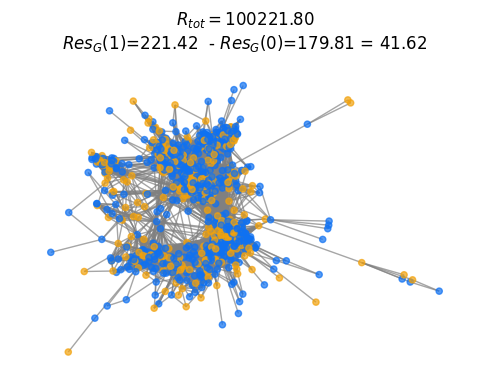

In [32]:
if DRAW:
    plt.figure(figsize=(5,4))
    G = nx.from_edgelist(GW.edgelist.numpy().T)
    R = GW.get_effective_resistance().cpu()
    rg0 = ermet.group_total_er(R, GW.sens==0).cpu().item()
    rg1 = ermet.group_total_er(R, GW.sens==1).cpu().item()
    plt.title(f'''$R_{{tot}} = {R.sum().item()/2:.2f}$
$Res_G(1)$={rg1:.2f}  - $Res_G(0)$={rg0:.2f} = {rg1-rg0:.2f}''')
    nx.draw(G, with_labels=False,pos=pos, node_size=20, node_color=node_colors, edge_color='gray', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./results/figures/graphs/{DATASET}{ADD_N_EDGES}ERPstrong.png', dpi=300, bbox_inches='tight')

In [33]:
idx  = np.arange(0, ADD_N_EDGES+1)

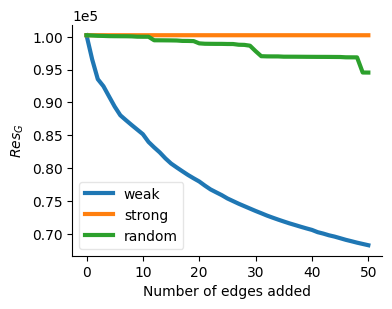

In [34]:
plt.figure(figsize=(4,3))
plt.plot(idx, weakTotalER, label='weak', linewidth=3)
plt.plot(idx, strongTotalER, label='strong', linewidth=3)
plt.plot(idx, randomedges, label='random', linewidth=3)
plt.legend(fancybox=True, framealpha=0.5)
plt.xlabel('Number of edges added')
plt.ylabel('$Res_G$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(3,4))
#disable frame on top and right
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

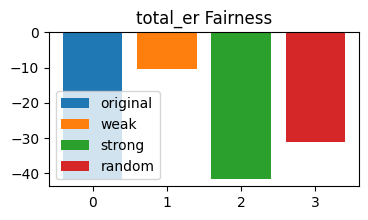

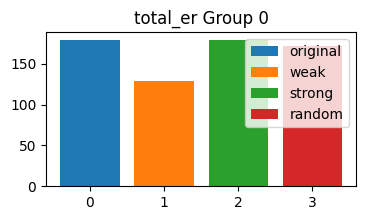

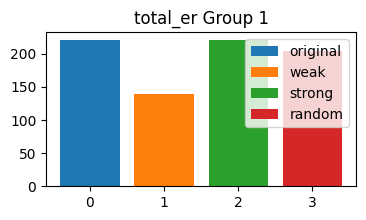

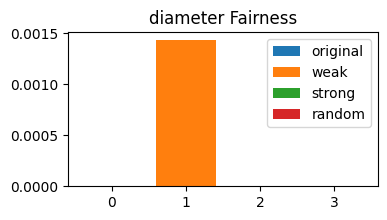

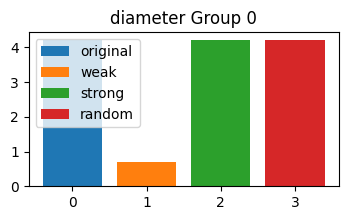

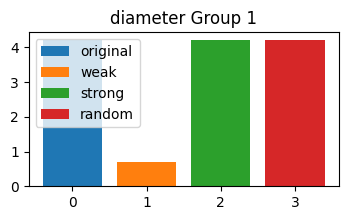

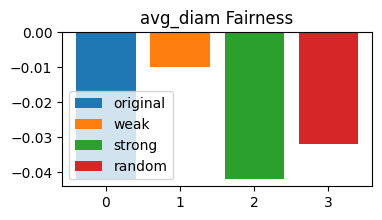

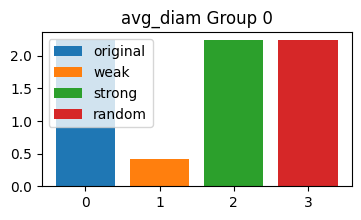

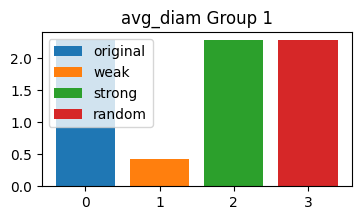

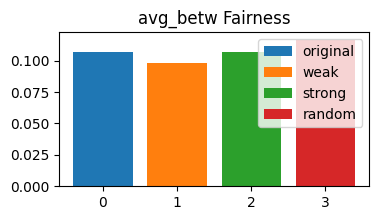

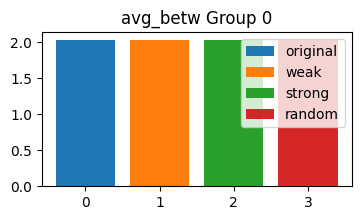

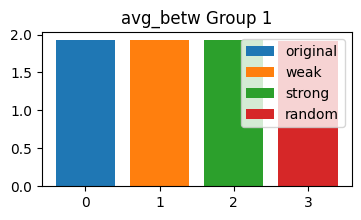

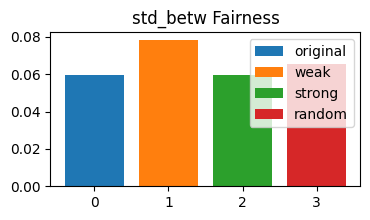

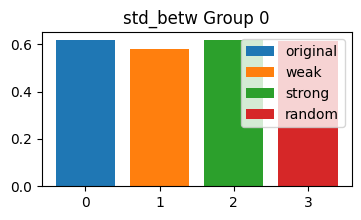

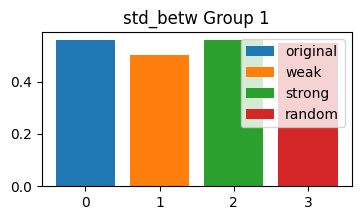

In [35]:
for i, m in enumerate(initial_0_metrics):
    plt.figure(figsize=(4,2))
    plt.bar(0, initial_0_metrics[m] - initial_1_metrics[m], label='original')
    plt.bar(1, weak_0_metrics[m] - weak_1_metrics[m], label='weak')
    plt.bar(2, strong_0_metrics[m] - strong_1_metrics[m], label='strong')
    plt.bar(3, random_0_metrics[m] - random_1_metrics[m], label='random')
    plt.title(f'{m} Fairness')
    plt.legend()
    plt.show()
    plt.figure(figsize=(4,2))
    plt.bar(0, initial_0_metrics[m], label='original')
    plt.bar(1, weak_0_metrics[m], label='weak')
    plt.bar(2, strong_0_metrics[m], label='strong')
    plt.bar(3, random_0_metrics[m], label='random')
    plt.title(f'{m} Group 0')
    plt.legend()
    plt.show()
    plt.figure(figsize=(4,2))
    plt.bar(0, initial_1_metrics[m], label='original')
    plt.bar(1, weak_1_metrics[m], label='weak')
    plt.bar(2, strong_1_metrics[m], label='strong')
    plt.bar(3, random_1_metrics[m], label='random')
    plt.title(f'{m} Group 1')
    plt.legend()
    plt.show()